In [ ]:
# default_exp dewarp_spatial_transformer_training

In [ ]:
#export
from ocr.core import *
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from ocr.ocr_dataset_brno import brno_ocr_config
from pathlib import PosixPath
import cv2

In [ ]:
images_dir = brno_ocr_config.MAIN_DIR/'templates'/'templates'

In [ ]:
train_dir = PosixPath('../data/dewarp/brno_templates/')

### Training Transformation Example

In [ ]:
for im_path in images_dir.iterdir():
    img = open_image(im_path)
    img = img.resize((img.shape[0],) + (1000,724)).refresh()
    break

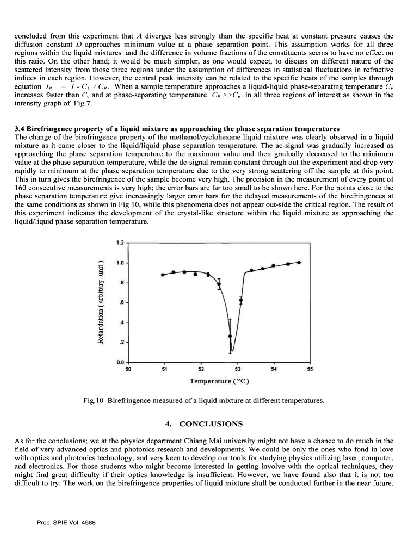

In [ ]:
img.show(figsize=(10,10))

In [ ]:
def rotate_image(image, angle):
    angle = random.choice(list(range(*angle)))
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    out_im = cv2.warpAffine(image, M, (nW, nH), borderValue=(255,255,255))
    return cv2.resize(out_im, (w,h))

In [ ]:
#export
def opencv_transform(fun):
    def transform(x, **kwargs):
        x = (image2np(x)*255).astype(np.uint8)
        x = fun(x, **kwargs)
        return tensor(x/255.).permute(2,0,1)
    return transform

# gaussian_blur = TfmPixel(_gaussian_blur)
def random_affine_transform(angle, p=1.0):
    return RandTransform(tfm=TfmPixel(opencv_transform(rotate_image)), kwargs={'angle':angle}, p=p, resolved={}, do_run=True, is_random=True, use_on_y=False)

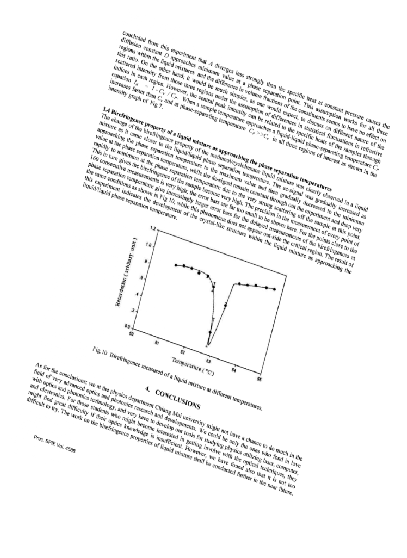

In [ ]:
im = img.apply_tfms([random_affine_transform(angle=(-20,20))])
im.show(figsize=(10,10))

### Spatial Transformer Transformation Example

In [ ]:
# [H,W,2] = F.affine_grid([B,2,3], tuple[4]), where tuple = (B,C,H,W)
# G = F.affine_grid(theta, tuple[4] ), where tuple = (B,C,H,W)

# [B,C,H,W] = F.grid_sample([B,C,H,W], [H,W,2])
# new_im = F.grid_sample(im, G)

In [ ]:
x = 1
y = 0
theta = 0
theta = torch.FloatTensor([
    [[np.cos(theta), -np.sin(theta), x],
     [np.sin(theta), np.cos(theta), y]]
])
print(theta.shape)
size = (1,1,100,200)
im = img.data # [0][None]
print(im.size())
size = (1,) + im.size()
G = F.affine_grid(theta, size)[0]
print(G.size())
# print(G[:, :, 0])
# print(G[:, :, 1])

torch.Size([1, 2, 3])
torch.Size([3, 1000, 724])
torch.Size([1000, 724, 2])


/home/dominykas/anaconda3/envs/nlp/lib/python3.7/site-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


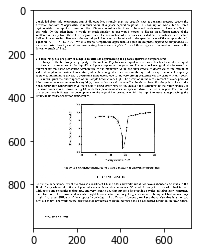

In [ ]:
plot(image2np(img.data))

In [ ]:
x = F.grid_sample(im[None], G[None])

/home/dominykas/anaconda3/envs/nlp/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


In [ ]:
x.shape

torch.Size([1, 3, 1000, 724])

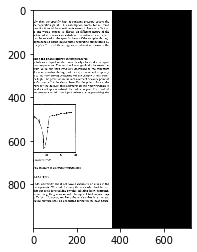

In [ ]:
plot(image2np(x[0]))

### Dataset

In [ ]:
def make_dataset(out_dir, size, num_elem=None): # size: tuple[2]
    im_paths = list(images_dir.iterdir())
    im_paths = im_paths if num_elem is None else im_paths[:num_elem]
    for im_path in progress_bar(im_paths):
        fn = str(im_path).split('/')[-1]
        im = open_image(im_path)
        im = im.resize((im.shape[0],) + size).refresh()
        im.save(out_dir/fn)

In [ ]:
w = 480
size = (int(w*1.3), w)

In [ ]:
make_dataset(train_dir, size, num_elem=4)

In [ ]:
train_transforms = [
#     crop_pad(),
    random_affine_transform(angle=(-20,20)),
#     symmetric_warp(magnitude=(-0.2, 0.2), p=1.),
#     rand_zoom(scale=(.2,.5), p=1.),
#     brightness(change=(0.4, 0.6), p=0.8),
#     contrast(scale=(0.8,1.2), p=0.8),
#     gaussian_blur(size=(1, 3), p=0.8)
]

valid_transforms = [
    random_affine_transform(angle=(-20,20))
#     rand_zoom(scale=(.5,.8), p=1.)
]
transforms = (train_transforms, valid_transforms)
# transforms = get_transforms()

In [ ]:
bs = 4
data = (ImageImageList.from_folder(train_dir)
#         .split_by_rand_pct(0.1, seed=42)
        .split_none()
        .label_from_func(lambda x:x)
        .transform(transforms, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats, do_y=False))
data

ImageDataBunch;

Train: LabelList (4 items)
x: ImageImageList
Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480)
y: ImageList
Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480),Image (3, 624, 480)
Path: ../data/dewarp/brno_templates;

Valid: LabelList (0 items)
x: ImageImageList

y: ImageList

Path: ../data/dewarp/brno_templates;

Test: None

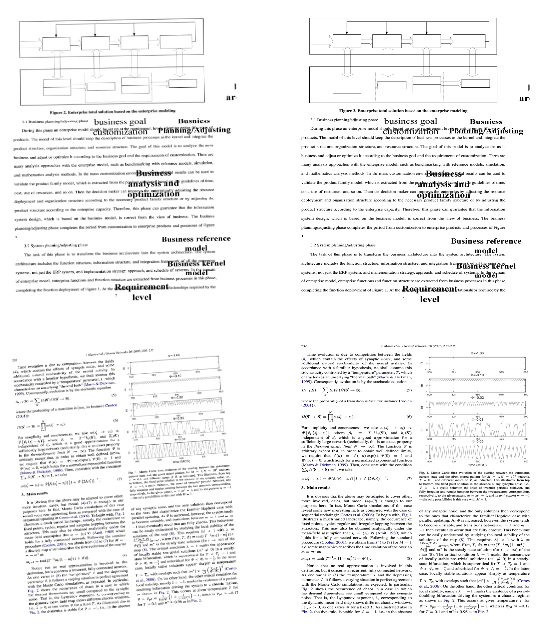

In [ ]:
data.show_batch(ds_type=DatasetType.Train, rows=2, figsize=(9,9))

### Model

In [ ]:
class LocalizationCNN(nn.Module):
    def __init__(self, nc):
        super().__init__()
        model = create_cnn_model(models.resnet18, nc=nc)
        self.body = model[0]
        self.head = model[1]
    
    def forward(self, x):
        x = self.body(x).detach()
        for name,f in self.head.named_children():
            if x.shape[0] == 1 and (name == '2' or name == '6'): continue
            x = f(x)
        return x

In [ ]:
torch.ones(1).expand(5)

tensor([1., 1., 1., 1., 1.])

In [ ]:
LocalizationCNN(3*2)(torch.zeros(2,3,100,100)).shape

torch.Size([2, 6])

In [ ]:
class SpatialTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        # Spatial transformer localization-network
        self.cnn = LocalizationCNN(nc=3*2)
        # Initialize the weights/bias with identity transformation
        self.cnn.head[-1].weight.data.zero_()
        self.cnn.head[-1].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def forward(self, x, align_corners=False):
        x = x.float()
        theta = self.cnn(x).view(-1, 2, 3) # [b,2,3]
        theta = torch.tanh(theta)
        grid = F.affine_grid(theta, x.size(), align_corners=align_corners)
        y = F.grid_sample(x, grid, align_corners=align_corners)
        return torch.sigmoid(y)

In [ ]:
SpatialTransformer()(torch.zeros(2,3,100,100)).shape

torch.Size([2, 3, 100, 100])

In [ ]:
class SpatialTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        # Spatial transformer localization-network
        self.cnn = LocalizationCNN(nc=1)
        self.cnn.head[-1].weight.data.zero_()
        self.cnn.head[-1].bias.data.copy_(torch.tensor([0], dtype=torch.float))

    def forward(self, x, align_corners=False):
        x = x.float()
        bs = x.shape[0]
        theta = self.cnn(x).view(-1, 1) # [b,2,3]
        theta = torch.tanh(theta)
        t1 =  torch.cos(theta.clone())
        t2 = -torch.sin(theta.clone())
        t3 =  torch.zeros(bs,1, dtype=theta.dtype, device=theta.device)
        t4 =  torch.sin(theta.clone())
        t5 =  torch.cos(theta.clone())
        t6 =  torch.zeros(bs,1, dtype=theta.dtype, device=theta.device)
        theta = torch.cat((t1,t2,t3,t4,t5,t6), dim=1)
        grid = F.affine_grid(theta.view(-1,2,3), x.size(), align_corners=align_corners)
        y = F.grid_sample(x, grid, align_corners=align_corners)
        return torch.sigmoid(y)

In [ ]:
SpatialTransformer()(torch.randn(2,3,100,100)).shape

torch.Size([2, 3, 100, 100])

### Feature Loss

In [ ]:
t = data.train_ds[0][1].data
t = torch.stack([t,t])
t.shape

torch.Size([2, 3, 624, 480])

In [ ]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [ ]:
gram_matrix(t).shape

torch.Size([2, 3, 3])

In [ ]:
from torchvision.models import vgg16_bn
base_loss = F.l1_loss
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [ ]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [ ]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [ ]:
feat_loss = FeatureLoss(vgg_m, blocks, [5,4,3,2,1])

### Training

In [ ]:
model = SpatialTransformer()

def loss(y_pred, y_true):
#     print(y_pred.max(), y_pred.min(), y_true.max(), y_true.min())
    return MSELossFlat()(y_pred, y_true)

loss = feat_loss
# loss = MSELossFlat()
learner = Learner(data, model, loss_func=loss, callback_fns=[ShowGraph], metrics=[], path='')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-05
Min loss divided by 10: 6.31E-08


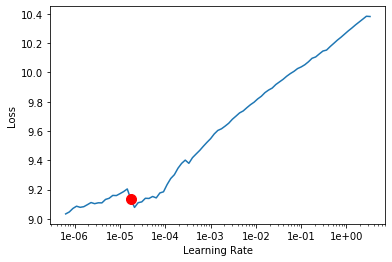

In [ ]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [ ]:
learner.fit_one_cycle(100, 1e-6)

epoch,train_loss,valid_loss,time
0,9.487102,#na#,00:01
1,8.329419,#na#,00:00
2,8.656793,#na#,00:00
3,8.890777,#na#,00:00
4,9.005117,#na#,00:00
5,9.043705,#na#,00:00
6,9.048198,#na#,00:00
7,9.090129,#na#,00:00
8,9.108849,#na#,00:01
9,9.130106,#na#,00:00


KeyboardInterrupt: 

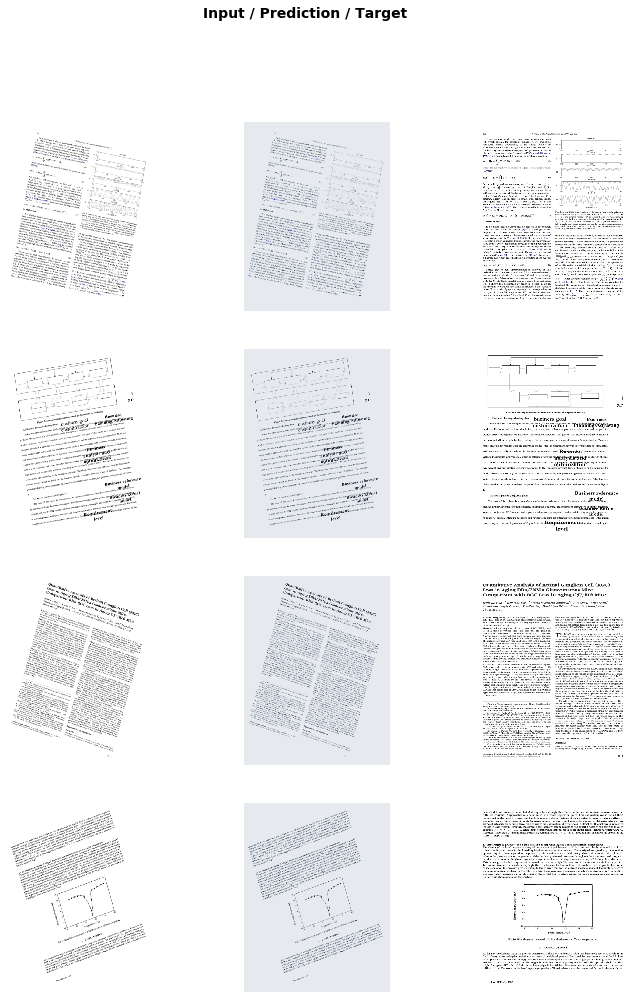

In [ ]:
learner.show_results(DatasetType.Train)

In [ ]:
class SpatialTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        print(xs.shape)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        print(theta.shape)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)
        return F.tanh(x)

In [ ]:
SpatialTransformer()(torch.zeros(2,3,28,28)).shape

torch.Size([2, 10, 3, 3])
torch.Size([2, 6])


torch.Size([2, 3, 28, 28])

In [ ]:
F.softmax()

TypeError: softmax() missing 1 required positional argument: 'input'

In [ ]:
x = 1
y = 0
theta = 0
theta = torch.FloatTensor([
    [[np.cos(theta), -np.sin(theta), x],
     [np.sin(theta), np.cos(theta), y]]
])
G = F.affine_grid(theta, torch.Size((1, 1, 100, 200)))[0]
print(G.size())
print(G[:, :, 0])
print(G[:, :, 1])

torch.Size([100, 200, 2])
tensor([[0.0000, 0.0101, 0.0201,  ..., 1.9799, 1.9899, 2.0000],
        [0.0000, 0.0101, 0.0201,  ..., 1.9799, 1.9899, 2.0000],
        [0.0000, 0.0101, 0.0201,  ..., 1.9799, 1.9899, 2.0000],
        ...,
        [0.0000, 0.0101, 0.0201,  ..., 1.9799, 1.9899, 2.0000],
        [0.0000, 0.0101, 0.0201,  ..., 1.9799, 1.9899, 2.0000],
        [0.0000, 0.0101, 0.0201,  ..., 1.9799, 1.9899, 2.0000]])
tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9798, -0.9798, -0.9798,  ..., -0.9798, -0.9798, -0.9798],
        [-0.9596, -0.9596, -0.9596,  ..., -0.9596, -0.9596, -0.9596],
        ...,
        [ 0.9596,  0.9596,  0.9596,  ...,  0.9596,  0.9596,  0.9596],
        [ 0.9798,  0.9798,  0.9798,  ...,  0.9798,  0.9798,  0.9798],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]])


In [ ]:
img.data

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [ ]:
F.grid_sample(x, grid)